Exame CES-30 / Técnicas de Bancos de Dados
============

Alunos
----------


Alexandre Ferreira Velho Muzio
Lucas Müller Machado de Oliveira
Matheus Mendes Ayres Costa Camargo


----------
Base de dados: Crime Incidents in Philadelphia
----------

Foram utilizados dados referentes a crimes cometidos na região da cidade de Philadelphia, PA, EUA. Os dados originais podem ser encontrados em [https://www.opendataphilly.org/dataset/crime-incidents](https://www.opendataphilly.org/dataset/crime-incidents). No entanto, os dados utilizados no trabalho foram retirados de [https://www.kaggle.com/mchirico/philadelphiacrimedata](https://www.kaggle.com/mchirico/philadelphiacrimedata), que trata de um simples pré-processamento dos dados.

A base de dados utilizada contém informações de 1º de Janeiro de 2006 até 21 de abril de 2016.

Ela contém informações dos incidentes registrados pelo Philadelphia Police Department e está descrita na próxima seção.


----------
Descrição da base de dados
----------


Dispõe-se das seguintes colunas principais:

 - **_id**: identificador;
 - **Dispatch_Date_Time**: Data e horário do incidente;
 - **Dispatch_Date**: Data do incidente;
 - **Dispatch_Time**: Horário do incidente;
 - **Location_Block**: Endereço do incidente;
 - **Lat**: Latitude;
 - **Longitude**: Longitude;
 - **Text_General_Code**: Tipo do crime registrado;
 - **Month**: Mês e ano do incidente.

----------
Ferramentas Utilizadas
----------

As análises e os gráficos foram feitos utilizando a linguagem de programação ***python***. A base de dados, provinda de um arquivo [*csv*](https://en.wikipedia.org/wiki/Comma-separated_values), foi carregada em memória com a biblioteca [***pandas***](http://pandas.pydata.org/). Os gráficos e relatórios foram gerados com o auxílio das bibliotecas [***matplotlib***](http://matplotlib.org/) e [***seaborn***](http://seaborn.pydata.org/). Para a modelagem, foi utilizado a biblioteca [***scikit-learn***](http://scikit-learn.org/), de aprendizado de máquina.


----------


Análise dos dados
==========

## Carregamento dos dados na memória com o uso do pacote *pandas*

In [122]:
import numpy as np
import pandas as pd
import datetime

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

In [13]:
FILE="crime.csv"

In [14]:
dateparse = lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')

d = pd.read_csv(FILE,
  header=0,names=['Dc_Dist', 'Psa', 'Dispatch_Date_Time', 'Dispatch_Date',
       'Dispatch_Time', 'Hour', 'Dc_Key', 'Location_Block', 'UCR_General',
       'Text_General_Code',  'Police_Districts', 'Month', 'Lon',
       'Lat'],dtype={'Dc_Dist':str,'Psa':str,
                'Dispatch_Date_Time':str,'Dispatch_Date':str,'Dispatch_Time':str,
                  'Hour':str,'Dc_Key':str,'Location_Block':str,
                     'UCR_General':str,'Text_General_Code':str,
              'Police_Districts':str,'Month':str,'Lon':float,'Lat':float},
             parse_dates=['Dispatch_Date_Time'],date_parser=dateparse)

# Fix Month to datetime Month
d['Month'] = d['Month'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m'))

In [15]:
Dat = pd.to_datetime(d.Dispatch_Date_Time)
d['month'] = Dat.dt.month
d['year'] = Dat.dt.year
d['day'] = Dat.dt.day

In [16]:
d.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat,month,year,day
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800,Other Assaults,NaN,2009-10-01,NaN,NaN,10,2009,2
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600,All Other Offenses,NaN,2009-05-01,NaN,NaN,5,2009,10
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800,Other Assaults,NaN,2009-08-01,NaN,NaN,8,2009,7
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500,Weapon Violations,20,2009-07-01,-75.130477,40.036389,7,2009,19
4,09,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600,All Other Offenses,8,2009-06-01,-75.166350,39.969532,6,2009,25


In [17]:
d.describe()

,Lon,Lat,month,year,day
count,2.174128e+06,2.174128e+06,2.191142e+06,2.191142e+06,2.191142e+06
mean,-7.514989e+01,3.999199e+01,6.520542e+00,2.010677e+03,1.570844e+01
std,5.973885e-02,4.536990e-02,3.317929e+00,3.147592e+00,8.788230e+00
min,-7.527773e+01,3.986999e+01,1.000000e+00,2.006000e+03,1.000000e+00
25%,-7.518487e+01,3.995564e+01,4.000000e+00,2.008000e+03,8.000000e+00
50%,-7.515666e+01,3.999102e+01,7.000000e+00,2.011000e+03,1.600000e+01
75%,-7.511839e+01,4.002741e+01,9.000000e+00,2.013000e+03,2.300000e+01
max,-7.495750e+01,4.013790e+01,1.200000e+01,2.016000e+03,3.100000e+01


## Tipos de crimes registrados

Mais adiante, serão feitas análises com base na ocorrência de cada um.

In [10]:
for crime in d['Text_General_Code'].dropna().unique().tolist():
    print (crime)

Other Assaults
All Other Offenses
Weapon Violations
Thefts
Burglary Non-Residential
Aggravated Assault Firearm
Theft from Vehicle
Disorderly Conduct
Vandalism/Criminal Mischief
Arson
Fraud
Robbery No Firearm
Vagrancy/Loitering
Motor Vehicle Theft
Recovered Stolen Motor Vehicle
Robbery Firearm
Embezzlement
Rape
DRIVING UNDER THE INFLUENCE
Forgery and Counterfeiting
Narcotic / Drug Law Violations
Burglary Residential
Other Sex Offenses (Not Commercialized)
Liquor Law Violations
Aggravated Assault No Firearm
Homicide - Criminal
Gambling Violations
Prostitution and Commercialized Vice
Public Drunkenness
Receiving Stolen Property
Homicide - Gross Negligence
Offenses Against Family and Children
Homicide - Justifiable


In [19]:
# Count of 1 for each record. Nice to have a standard column name
d['Value'] = 1


# Use sum. We're summing up all  Dc_Dist
g=d.groupby(['Month','Text_General_Code'])['Value'].sum().reset_index()

g.head()

,Month,Text_General_Code,Value
0,2006-01-01,Aggravated Assault Firearm,277
1,2006-01-01,Aggravated Assault No Firearm,468
2,2006-01-01,All Other Offenses,4295
3,2006-01-01,Arson,44
4,2006-01-01,Burglary Non-Residential,246


## Analisando a frequência de ocorrência de crimes por tipo:


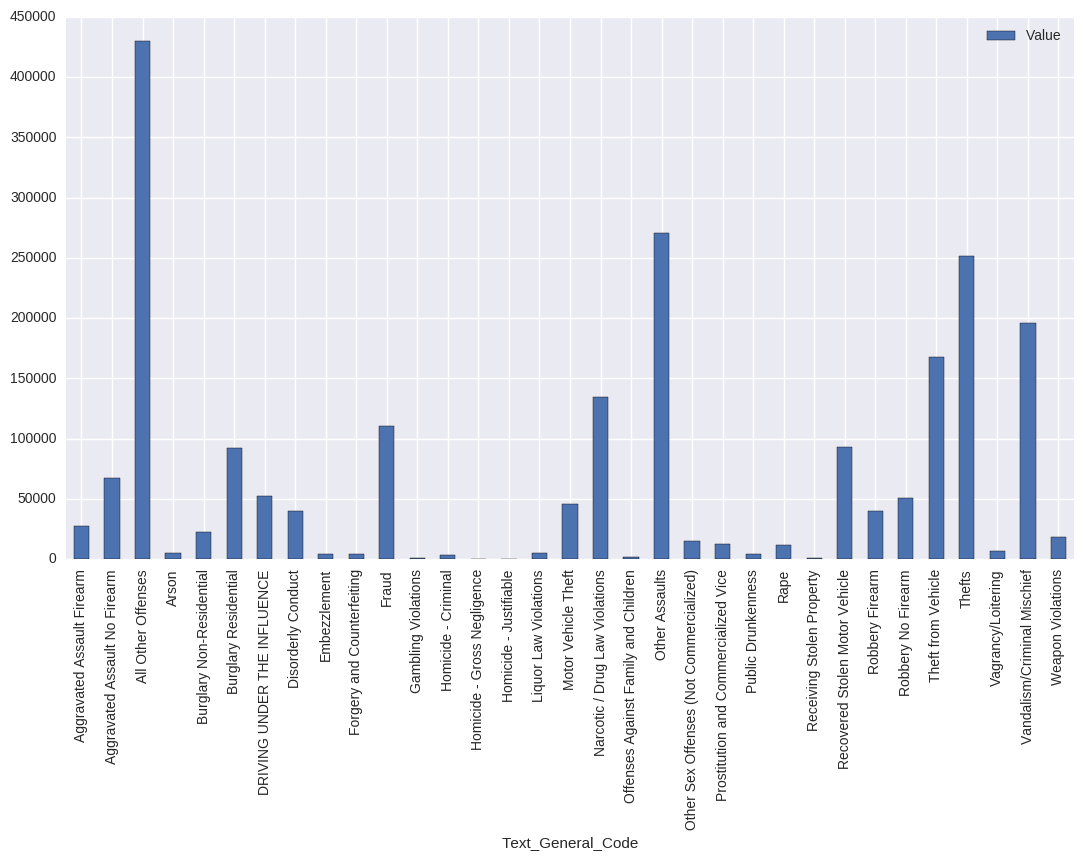

In [20]:
gg=d.groupby(['Text_General_Code'])['Value'].sum().reset_index()
bar_d = gg[['Text_General_Code', 'Value']].dropna()
bar_d.plot.bar(x='Text_General_Code', y='Value')

## Analisando o número de crimes por tipo para cada ano (2006 -> 2016):

Pode-se perceber uma queda brusca em invasões de estabelecimentos comerciais (Burglary - Non-Residential) no ano de 2008, que se manteve.

Houve, também, queda em crimes de incêncio (Arson) no mesmo ano.

Em geral, os outros tipos tiveram uma queda razoável com exceção de roubos e fraude (Theft e Fraud).


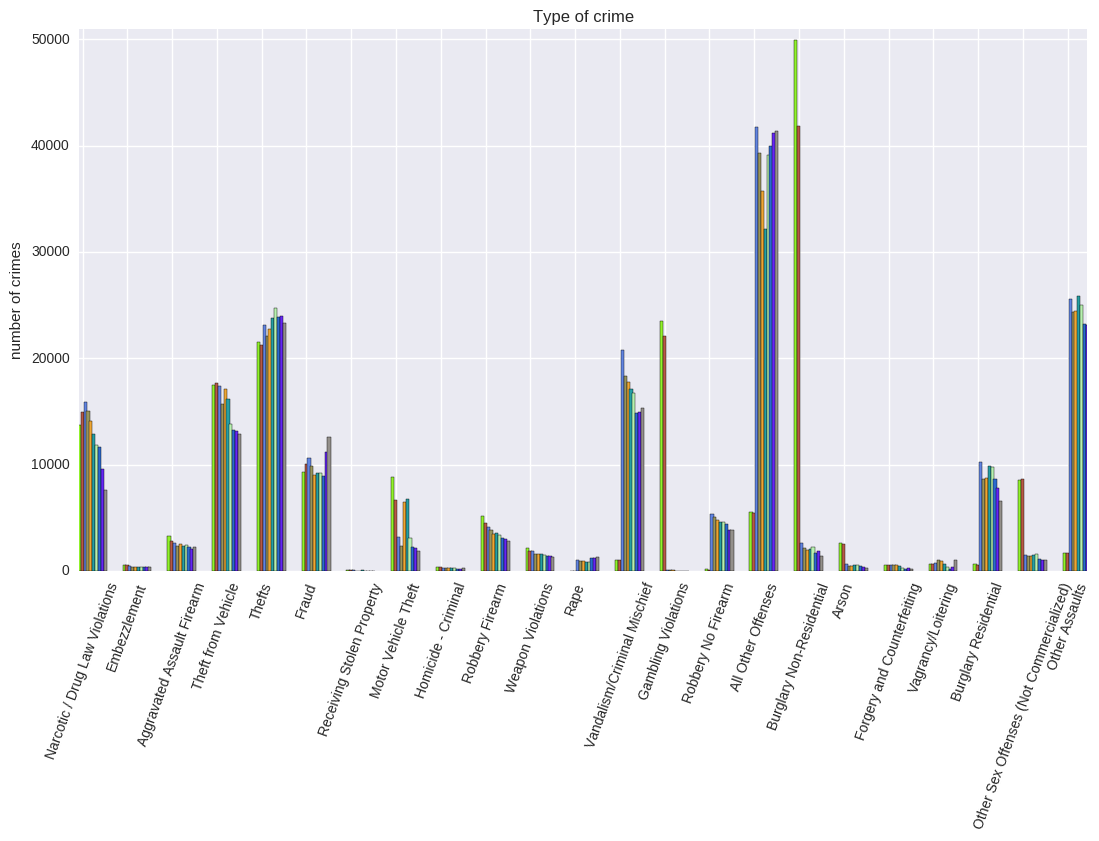

In [21]:
color = np.random.rand( d.Text_General_Code.value_counts(sort= False).shape[0], 3)
c = 0
rcParams['figure.figsize'] = 13, 7
fig, ax = plt.subplots()
for i in range(2006, 2016):
    crimes = np.array( d.Text_General_Code[d.year == i].value_counts(sort= False))
    N = crimes.shape[0]
    ind = np.arange(N)*1.2  
    width = 0.085
    p1 = plt.bar( ind + width*c*0.9, crimes, width, align="center", color= color[c])
    plt.ylabel('number of crimes')
    plt.title('Type of crime')
    plt.xticks(ind+width, d.Text_General_Code[d.year == i].value_counts(sort= False).index, rotation = 70)
    plt.axis([0, 27, 0.0, 51000])
    c += 1

plt.show()

## Analisando homicídio doloso e estupro

Há uma variação grande do número de homicídos dolosos mês a mês, porém, o gráfico a seguir mostra que o número tende a diminuir nos últimos anos, sobretudo nos últimos 3 anos.

De forma semelhante, há uma grande variação do número de estupros mês a mês, mas tem aumentado nos últimos 3 anos.


In [132]:
homicide_d = g[g['Text_General_Code'] == 'Homicide - Criminal']
rape_d = g[g['Text_General_Code'] == 'Rape']

In [13]:
homicide_d.head()

,Month,Text_General_Code,Value
12,2006-01-01,Homicide - Criminal,24
44,2006-02-01,Homicide - Criminal,22
75,2006-03-01,Homicide - Criminal,30
107,2006-04-01,Homicide - Criminal,33
139,2006-05-01,Homicide - Criminal,30


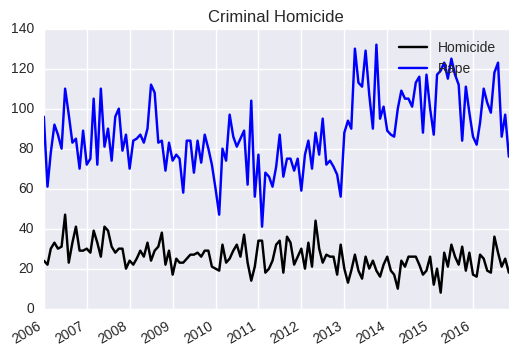

In [138]:
# Red dot with Line
fig, ax = plt.subplots()
ax.plot_date(homicide_d['Month'], homicide_d['Value'], 'k', label='Homicide')
# ax.plot_date(homicide_d['Month'], homicide_d['Value'], 'ro')
ax.plot_date(rape_d['Month'], rape_d['Value'], 'k', color='b', label='Rape')
# ax.plot_date(rape_d['Month'], rape_d['Value'], 'ro', color='b')
ax.set_title("Criminal Homicide")

plt.legend()
fig.autofmt_xdate()
plt.show()

## Ocorrências criminais pela cidade

Nesta seção, serão analisados as ocorrências geograficamente. O primeiro mapa abaixo mostra a ocorrência de todos os tipos. Ele mostra que há uma ocorrência maior no centro da cidade e em alguns bairros específicos há alguma concentração. Em seguida, serão avaliados os diferentes tipos.


http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=-75.277728,39.875032,-74.95754000000001,40.137445&bboxSR=4269&imageSR=4269&size=800,655&dpi=96&format=png32&f=image


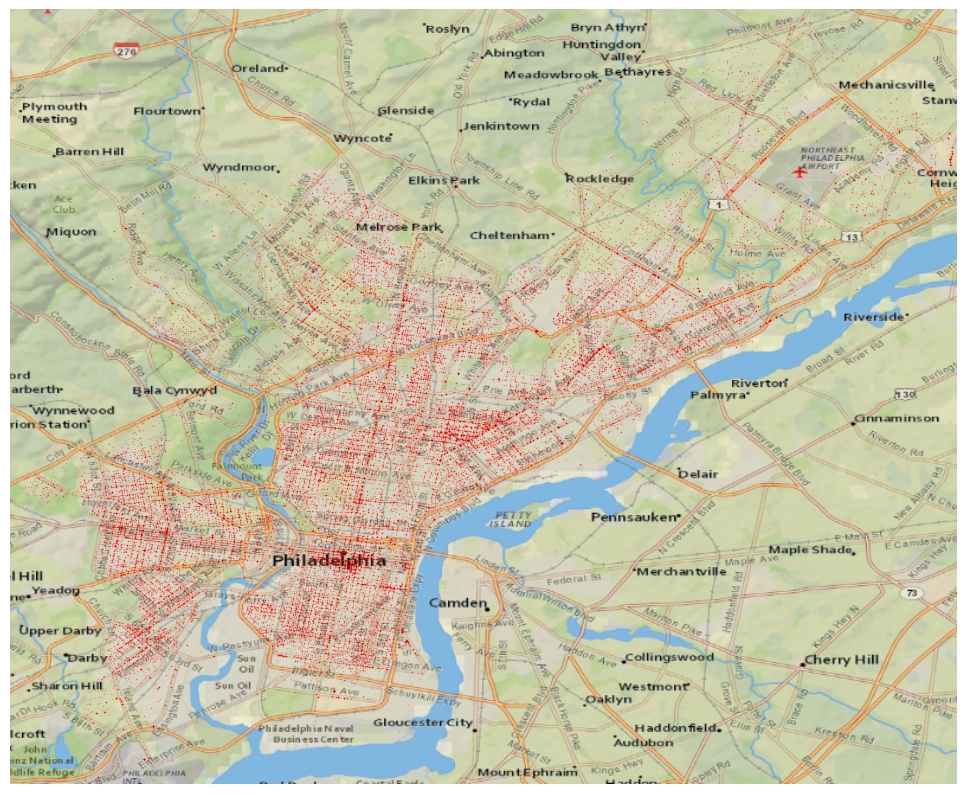

In [139]:
m = Basemap(projection='mill', llcrnrlat=d.Lat.min(), urcrnrlat=d.Lat.max(), 
            llcrnrlon=d.Lon.min(), urcrnrlon=d.Lon.max(), resolution='c', epsg=4269)
x, y = m(tuple(d.Lon[(d.Lon.isnull()==False) & (Dat.dt.year == 2015)]), \
         tuple(d.Lat[(d.Lat.isnull() == False) & (Dat.dt.year == 2015)]))

plt.figure(figsize=(20,10))
m.arcgisimage(service="NatGeo_World_Map", xpixels=800, verbose=True)
m.plot(x,y,'ro',markersize=1, alpha=.3 )
plt.show()

# Modelagem


Para a primeira modelagem, usa-se o algoritmo Random Forest.

In [23]:
d.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat,month,year,day,Value
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800,Other Assaults,NaN,2009-10-01,NaN,NaN,10,2009,2,1
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600,All Other Offenses,NaN,2009-05-01,NaN,NaN,5,2009,10,1
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800,Other Assaults,NaN,2009-08-01,NaN,NaN,8,2009,7,1
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500,Weapon Violations,20,2009-07-01,-75.130477,40.036389,7,2009,19,1
4,09,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600,All Other Offenses,8,2009-06-01,-75.166350,39.969532,6,2009,25,1


In [121]:
#Feature extraction

#Type conversions
d = d.dropna(subset=['Text_General_Code'])
d['Hour'] = d['Hour'].astype(int)
d['Dc_Dist'] = d['Dc_Dist'].astype(int)

dic = {}
inv_dic = {}
ind = 0
for crime in d['Text_General_Code'].dropna().unique().tolist():
    dic[crime] = ind
    inv_dic[ind] = crime
    ind += 1

# le = preprocessing.LabelEncoder()
# le.fit(d[predict].unique().tolist())

# le.fitnp.array('Othe(r Assaults'))

# d['Text_General_Code_Feat'] = s = pd.Series(d[predict].factorize())
# d.head()
# f = lambda x: le.transform(np.array([x]))[0]

# f('Other Assaults')

d['Text_General_Code_Feat'] = d['Text_General_Code'].dropna().apply(lambda x: dic[x])

d = d.sample(frac=1).reset_index(drop=True)
d.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat,month,year,day,Value,Text_General_Code_Feat
0,25,2,2012-10-22 17:51:00,2012-10-22,17:51:00,17,201225088352,400 BLOCK E ROCKLAND ST,500,Burglary Residential,18,2012-10-01,-75.117624,40.023815,10,2012,22,1,10
1,12,E,2007-08-19 12:40:00,2007-08-19,12:40:00,12,200712073931,2500 BLOCK ISLAND AVE,500,Burglary Non-Residential,9,2007-08-01,-75.243170,39.913114,8,2007,19,1,17
2,18,3,2010-11-09 13:34:00,2010-11-09,13:34:00,13,201018074878,3300 BLOCK MARKET ST,600,Thefts,14,2010-11-01,-75.189560,39.955568,11,2010,9,1,0
3,19,D,2009-08-26 16:44:00,2009-08-26,16:44:00,16,200919078471,2400 BLOCK N 56TH ST,600,Thefts,15,2009-08-01,-75.235473,39.993104,8,2009,26,1,0
4,39,C,2008-08-26 00:37:00,2008-08-26,00:37:00,0,200839061571,3300 BLOCK N 18TH ST,800,Other Assaults,21,2008-08-01,-75.158767,40.004504,8,2008,26,1,3


In [130]:
features = ['Dc_Dist','Hour', 'day', 'month']
predict = 'Text_General_Code_Feat'

X = d[features].values
y = d[predict].values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

In [131]:
clf.score(X_test, y_test)

0.15677100569433192